In [ ]:

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from IPython import display
import plotly as plotly
%matplotlib inline
import seaborn as sns

import calendar
import datetime as dt
from datetime import timedelta, date
from pprint import pprint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from scipy.stats import randint as sp_randint
from time import time
import pickle

import warnings
warnings.filterwarnings('ignore')

random_state = 123

In [ ]:
import os

# Create the directory if it doesn't exist
directory = "C:/content/Panama_Case_Study"
if not os.path.exists(directory):
    os.makedirs(directory)

# Change the current working directory
try:
    os.chdir(directory)
    print("Current working directory:", os.getcwd())
except FileNotFoundError:
    print("Directory not found.")


Current working directory: /content/C:/content/Panama_Case_Study


In [ ]:
legend_elements = [Patch(facecolor='#5D666D', label='Training weeks'),
                   Patch(facecolor='#BFD630', label='Testing weeks')]
fig, ax = plt.subplots(figsize=(20,1))
ax.legend(handles=legend_elements, loc='center')
plt.axis('off')
plt.show()
# Display gif
display.Image('/content/Panama_Case_Study/Animated_3D_plot.gif')

Output hidden; open in https://colab.research.google.com to view.

Text(0, 0.5, 'Load (MWh)')

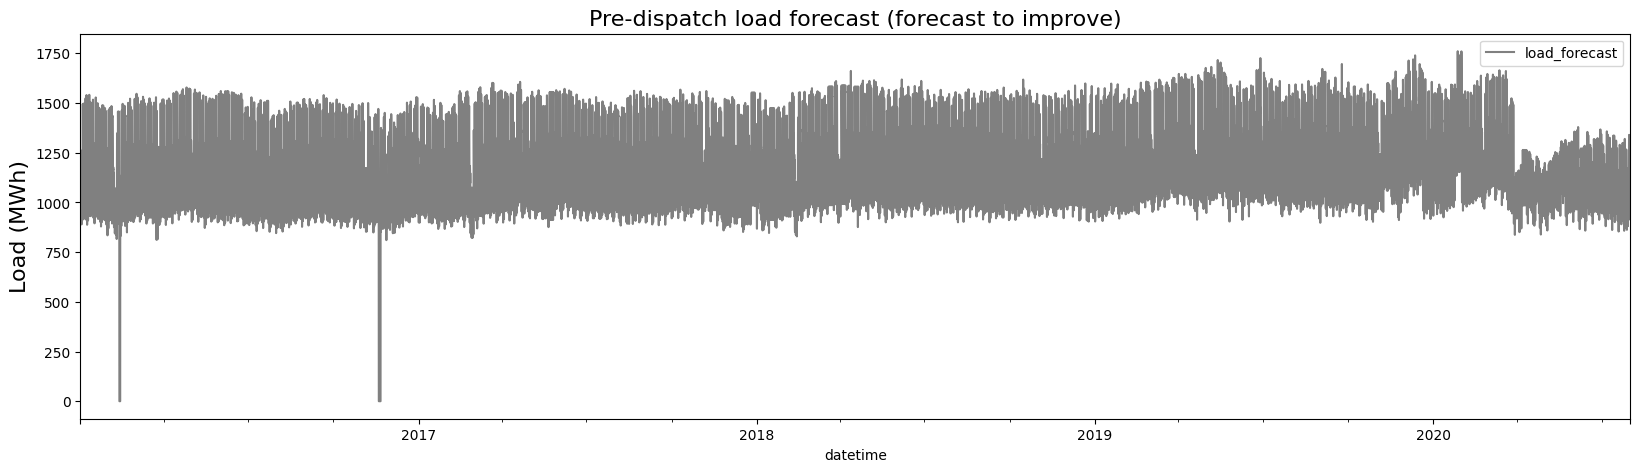

In [ ]:
pre_disp_df = pd.read_csv('/content/Panama_Case_Study/weekly pre-dispatch forecast.csv')
pre_disp_df.set_index('datetime', inplace=True)

pre_disp_df.index = pd.to_datetime(pre_disp_df.index)

# plot weekly pre-dispatch forecast (forecast to improve)
pre_disp_df.plot(figsize=(20,5), color='grey')
plt.title('Pre-dispatch load forecast (forecast to improve)', fontsize=16)
plt.ylabel('Load (MWh)', fontsize=16)

In [ ]:
train_dict = pd.read_csv('/content/Panama_Case_Study/train_dataframes.csv', index_col=0)
test_dict = pd.read_csv('/content/Panama_Case_Study/test_dataframes.csv', index_col=0)


In [ ]:
keys = list(test_dict.keys())
print(keys)

['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc', 'DEMAND']


In [ ]:
train_dict

,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
datetime,,,,,,,,,,,
2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472
...,...,...,...,...,...,...,...,...,...,...,...
2019-04-09 20:00:00,1362.1477,1376.6220,1335.4711,1360.112475,4,0,0,0,20,29.044763,1397.5788
2019-04-09 21:00:00,1330.7467,1338.3879,1305.3631,1332.959900,4,0,0,0,21,28.539545,1350.5093
2019-04-09 22:00:00,1275.5550,1281.6932,1240.1208,1279.486450,4,0,0,0,22,28.163232,1308.7955


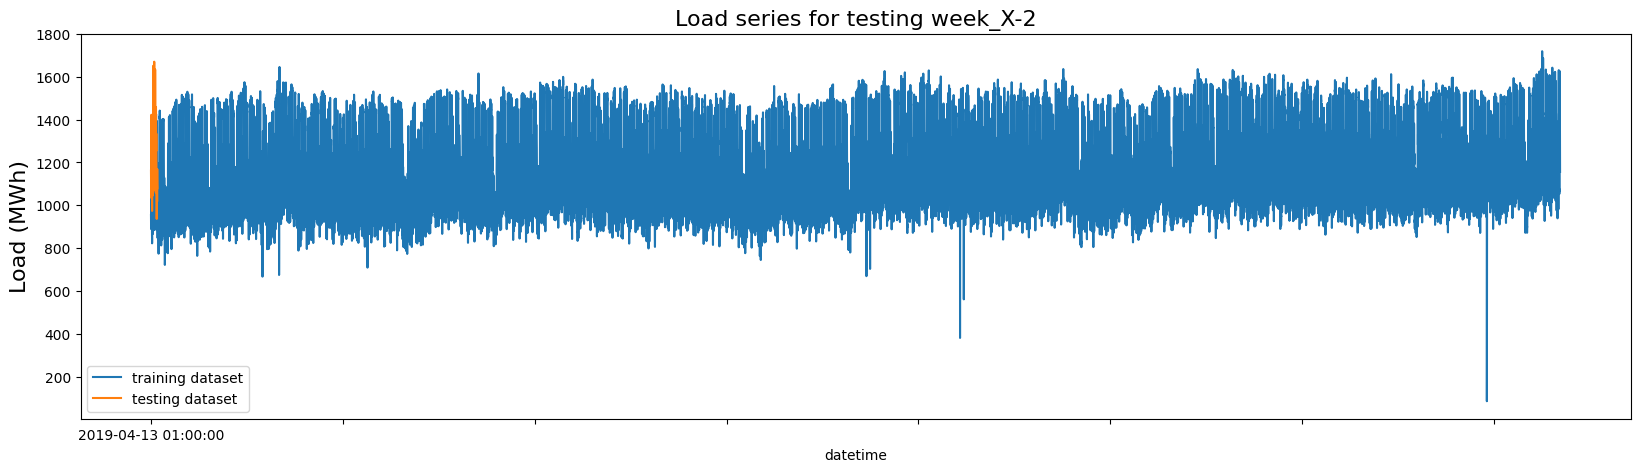

In [ ]:
train_dict['DEMAND'].plot(figsize=(20,5), label='training dataset')
test_dict['DEMAND'].plot(figsize=(20,5), label='testing dataset')
plt.ylabel('Load (MWh)', fontsize=16)
plt.title('Load series for testing ' + keys[0],fontsize=16)
plt.legend();

In [ ]:
df = pd.read_csv('/content/train_dataframes.csv')
df.index = pd.to_datetime(df.index)
df.head(10)

,datetime,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
1970-01-01 00:00:00.000000000,2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
1970-01-01 00:00:00.000000001,2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
1970-01-01 00:00:00.000000002,2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
1970-01-01 00:00:00.000000003,2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
1970-01-01 00:00:00.000000004,2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472
1970-01-01 00:00:00.000000005,2015-01-31 06:00:00,912.5080,848.4718,879.2323,877.027925,1,1,0,0,6,24.830194,922.1737
1970-01-01 00:00:00.000000006,2015-01-31 07:00:00,927.5976,897.8229,932.4876,920.381925,1,1,0,0,7,25.799951,939.9442
1970-01-01 00:00:00.000000007,2015-01-31 08:00:00,1075.3486,1021.6720,1048.9720,1057.194625,1,1,0,0,8,26.980310,1077.8575
1970-01-01 00:00:00.000000008,2015-01-31 09:00:00,1116.6425,1108.9439,1167.9074,1138.178750,1,1,0,0,9,28.031824,1179.6601
1970-01-01 00:00:00.000000009,2015-01-31 10:00:00,1121.9048,1165.4756,1257.5069,1189.291375,1,1,0,0,10,28.906061,1255.1569


In [ ]:
df.describe()

,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
count,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000,36720.000000
mean,1172.405388,1171.627655,1170.818351,1171.860987,3.996187,0.286247,0.063399,0.710458,11.500000,27.350902,1174.246264
std,191.916845,191.649220,191.535919,184.017825,1.999642,0.452013,0.243682,3.171065,6.922281,1.685151,192.028058
min,85.192500,85.192500,85.192500,793.602650,1.000000,0.000000,0.000000,0.000000,0.000000,22.953455,85.192500
25%,1004.807450,1004.093150,1003.349825,1005.241544,2.000000,0.000000,0.000000,0.000000,5.750000,26.111856,1006.470375
50%,1160.983850,1160.245150,1158.946650,1166.273912,4.000000,0.000000,0.000000,0.000000,11.500000,27.072916,1162.468800
75%,1318.602650,1317.705275,1316.997800,1310.217306,6.000000,1.000000,0.000000,0.000000,17.250000,28.514787,1320.387025
max,1719.043900,1645.477300,1645.477300,1608.401625,7.000000,1.000000,1.000000,22.000000,23.000000,35.039575,1719.043900


Text(0.5, 1.0, 'Ennergy Distribution')

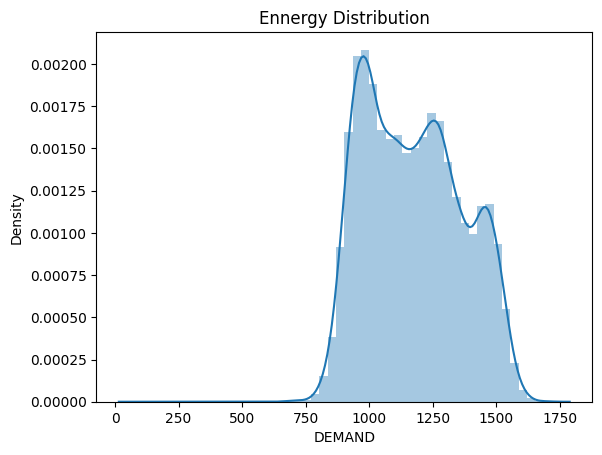

In [ ]:
sns.distplot(df["DEMAND"])
plt.title("Ennergy Distribution")

In [ ]:
newDataSet = df.head(23)
newDataSet

,datetime,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
1970-01-01 00:00:00.000000000,2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
1970-01-01 00:00:00.000000001,2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
1970-01-01 00:00:00.000000002,2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
1970-01-01 00:00:00.000000003,2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
1970-01-01 00:00:00.000000004,2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472
1970-01-01 00:00:00.000000005,2015-01-31 06:00:00,912.5080,848.4718,879.2323,877.027925,1,1,0,0,6,24.830194,922.1737
1970-01-01 00:00:00.000000006,2015-01-31 07:00:00,927.5976,897.8229,932.4876,920.381925,1,1,0,0,7,25.799951,939.9442
1970-01-01 00:00:00.000000007,2015-01-31 08:00:00,1075.3486,1021.6720,1048.9720,1057.194625,1,1,0,0,8,26.980310,1077.8575
1970-01-01 00:00:00.000000008,2015-01-31 09:00:00,1116.6425,1108.9439,1167.9074,1138.178750,1,1,0,0,9,28.031824,1179.6601
1970-01-01 00:00:00.000000009,2015-01-31 10:00:00,1121.9048,1165.4756,1257.5069,1189.291375,1,1,0,0,10,28.906061,1255.1569


In [ ]:
newDataSet = df.head(23)
newDataSet

,datetime,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
1970-01-01 00:00:00.000000000,2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
1970-01-01 00:00:00.000000001,2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
1970-01-01 00:00:00.000000002,2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
1970-01-01 00:00:00.000000003,2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
1970-01-01 00:00:00.000000004,2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472
1970-01-01 00:00:00.000000005,2015-01-31 06:00:00,912.5080,848.4718,879.2323,877.027925,1,1,0,0,6,24.830194,922.1737
1970-01-01 00:00:00.000000006,2015-01-31 07:00:00,927.5976,897.8229,932.4876,920.381925,1,1,0,0,7,25.799951,939.9442
1970-01-01 00:00:00.000000007,2015-01-31 08:00:00,1075.3486,1021.6720,1048.9720,1057.194625,1,1,0,0,8,26.980310,1077.8575
1970-01-01 00:00:00.000000008,2015-01-31 09:00:00,1116.6425,1108.9439,1167.9074,1138.178750,1,1,0,0,9,28.031824,1179.6601
1970-01-01 00:00:00.000000009,2015-01-31 10:00:00,1121.9048,1165.4756,1257.5069,1189.291375,1,1,0,0,10,28.906061,1255.1569


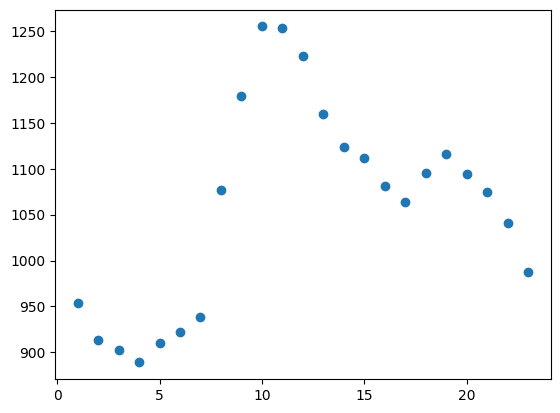

In [ ]:
x = [i for i in newDataSet['hourOfDay']]
y = [int(j) for j in newDataSet['DEMAND']]
plt.scatter(x, y)
plt.show()

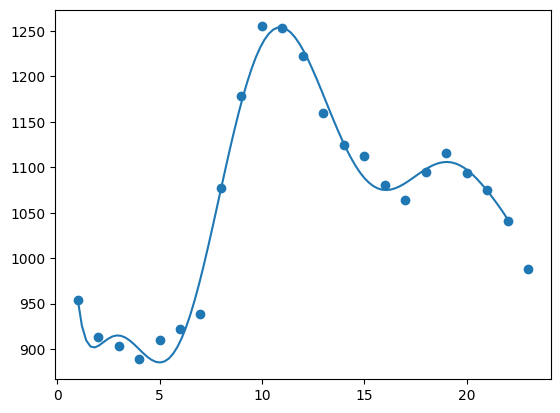

In [ ]:
mymodel = np.poly1d(np.polyfit(x, y, 10))

myline = np.linspace(1, 22, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.show()

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y, mymodel(x)))

0.9840416310458548


In [ ]:
predict = mymodel(15)
predict

1088.0743195504701

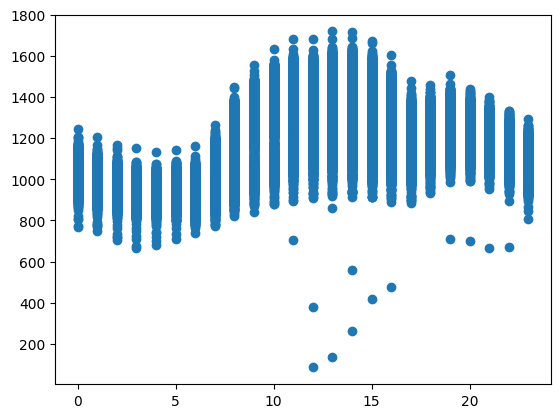

In [ ]:
# Linear Regression
p = [i for i in df['hourOfDay']]
q = [int(j) for j in df['DEMAND']]
plt.scatter(p,q)
plt.show()

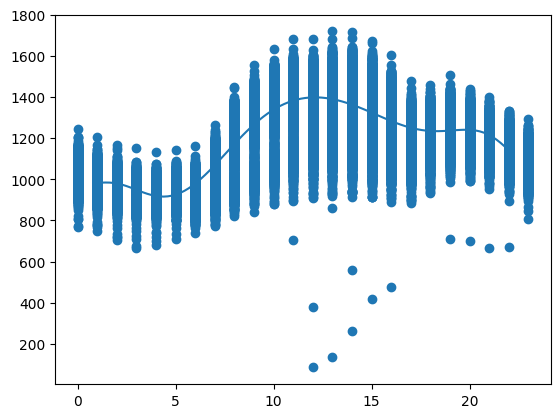

In [ ]:
mymodel = np.poly1d(np.polyfit(p, q, 10))

myline = np.linspace(1, 22, 100)

plt.scatter(p, q)
plt.plot(myline, mymodel(myline))
plt.show()

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(q, mymodel(p)))

0.6716110929565549
